In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
# torch.cuda.device_count()

Running on the GPU


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import pandas as pd
import numpy as np

Data = pd.read_csv('kuairand_sequence.csv',index_col=0)
# data['user_id'].value_counts()

In [4]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader,TensorDataset

max_length = 100
num_user = len(Data['user_id'].unique())
state_feature = len(Data.columns) - 1
action_feature = 3

uid = Data['user_id'].unique()
uid
print(uid.shape)
print(state_feature)

(6051,)
27


In [5]:
State = np.zeros(((num_user,max_length,state_feature)))
Action = np.zeros((num_user,max_length,action_feature))
Click = np.zeros((num_user,max_length))

j = 0
for i in uid:
    state_sequence = np.array(Data[Data['user_id']==i])[:-1]
    # state_sequence = np.array(data[data['user_id']==i].drop(['short','mid','long'],axis=1))
    action_sequence = np.array(Data[Data['user_id']==i][['short','mid','long']])[1:]
    click_sequence = np.array(Data[Data['user_id']==i]['is_click'])[1:]
    # action_sequence = np.array(data[data['user_id']==i][['short','mid','long']])
    # print(action_sequence)
    state = np.pad(state_sequence,((0,max_length-len(state_sequence)),(0,0)))[:,1:]
    action = np.pad(action_sequence,((0,max_length-len(action_sequence)),(0,0)))
    click = np.pad(click_sequence,((0,max_length-len(click_sequence))))
    # print(click)
    State[j] = state
    Action[j] = action
    Click[j] = click
    j += 1
print(len(State))
print(len(Action))
print(len(Click))
print(Click.shape)

6051
6051
6051
(6051, 100)


In [6]:
length = 20
max_number_traj = 4000

number_traj = 0
def Select_trajectory(X,Y,Z,number_traj):
    Select_states = []
    Select_actions = []
    Select_clicks = []
    # for s in range(number_traj):
    while True:
        i = random.randint(0,len(X)-1)
        select_state = X[i]
        select_action = Y[i]
        select_click = Z[i]
        # print(select_state)
        # print(select_action)
        for k in range(0,max_length):
            # print(select_episode[k])
            if select_state[k].any() == 0:
                max_episode_length = k
                break
        # print(k)
        # print(max_episode_length)
        if max_episode_length >= length + 1:
            j = random.randint(0,max_episode_length-length-1)
            select_state = select_state[j:j+length]
            select_action = select_action[j:j+length]
            select_click = select_click[j:j+length]
            Select_states.append(select_state)
            Select_actions.append(select_action)
            Select_clicks.append(select_click)
            number_traj += 1
        # print(select_trajectory)
        if number_traj == max_number_traj:
            break
    return np.array(Select_states),np.array(Select_actions),np.array(Select_clicks)

X , Y , Z = Select_trajectory(State,Action,Click,number_traj)
print(len(X))

4000


In [7]:
np.random.seed(2023)
per = np.random.permutation(X.shape[0])
# print(per)
X = X[per]
Y = Y[per]
Z = Z[per]
# print(sum(Y))

In [9]:
def split_data(State, Action, Reward, timestep, input_size, output_size):

    train_size = int(np.round(0.8 * X.shape[0]))
    print(train_size)

    x_train = X[: train_size, :].reshape(-1, timestep,input_size)
    y_train = Y[: train_size].reshape(-1,timestep, output_size)
    z_train = Z[: train_size].reshape(-1,timestep, 1)

    x_test = X[train_size:, :].reshape(-1, timestep,input_size)
    y_test = Y[train_size:].reshape(-1,timestep, output_size)
    z_test = Z[train_size:].reshape(-1,timestep, 1)

    return [x_train, y_train, z_train, x_test, y_test, z_test]

# State, Action, Reward(is_click)
X1,Y1,Z1,X2,Y2,Z2=split_data(X,Y,Z,length,state_feature,action_feature)
# print(len(X2))
# print(len(X2))
X1,Y1=torch.from_numpy(X1).to(torch.float32).to(device),torch.from_numpy(Y1).to(torch.float32).to(device)
# print(Y2)
X2,Y2=torch.from_numpy(X2).to(torch.float32).to(device),torch.from_numpy(Y2).to(torch.float32).to(device)
Z1,Z2=torch.from_numpy(Z1).to(torch.float32).to(device),torch.from_numpy(Z2).to(torch.float32).to(device)
# X,Y=torch.from_numpy(X).to(torch.float32),torch.from_numpy(Y).to(torch.float32)
train_ids = TensorDataset(X1,Y1,Z1)
test_ids = TensorDataset(X2,Y2,Z2)
# data_ids = TensorDataset(X,Y)
# print(train_ids[12])
print(test_ids[0])

3200
(tensor([[0.6522, 0.9785, 0.0000, 0.0000, 0.0762, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5000, 0.0408, 0.7946, 0.5000, 0.0000, 0.1111, 0.8653, 1.0000, 0.7500],
        [0.6522, 0.9786, 0.0000, 0.0000, 0.0814, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5000, 0.0408, 0.7946, 0.5000, 0.0000, 0.1111, 0.8653, 1.0000, 0.7500],
        [0.6522, 0.9786, 0.0000, 0.0000, 0.1005, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5000, 0.0408, 0.7946, 0.5000, 0.0000, 0.1111, 0.8653, 1.0000, 0.7500],
        [0.6522, 0.9790, 0.0000, 0.0000, 0.0683, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5000, 0.0408, 0.7946, 0.5000, 0.0000, 0.1111, 0.8653, 1.0000, 0.7500],
        [0.6522, 0

In [10]:
print(X1.shape)

torch.Size([3200, 20, 27])


In [12]:
# X = torch.rand(2,20,5)
# Y = X.permute(0, 2, 1)
# print(Y.shape)
# torch.matmul(X, Y).shape
# # [batchsize seq hidden_size]

In [13]:
class OnlineDesionTransformer(torch.nn.Module):
    def __init__(self, feature_size, hidden_size, output_size):

        # super().__init__(state_dim, act_dim, max_length=max_length)
        super(OnlineDesionTransformer,self).__init__() 
        # self.transformer = GPT2Model(config)

        # self.embed_timestep = nn.Embedding(max_ep_len, hidden_size)
        # self.embed_return = torch.nn.Linear(1, hidden_size)
        # self.embed_state = torch.nn.Linear(self.state_dim, hidden_size)
        # self.embed_action = torch.nn.Linear(self.act_dim, hidden_size)
        self.sqrt_size = np.sqrt(hidden_size)
        self.query = nn.Linear(feature_size, hidden_size)
        self.key = nn.Linear(feature_size, hidden_size)
        self.value = nn.Linear(feature_size, hidden_size)
        self.embed_ln = nn.LayerNorm(hidden_size)
        self.softmax = nn.Softmax(dim=-1)
        self.sigmoid = nn.Sigmoid()
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.LeakyReLU = nn.LeakyReLU()
        self.LayerNorm = nn.LayerNorm(hidden_size)
    # def attention(query, key, value, mask=mask, dropout=None):
    #     "Compute 'Scaled Dot Product Attention'"
    #     d_k = query.size(-1)
    #     scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)
    #     print(scores)
    #     if mask is not None:
    #         scores = scores.masked_fill(mask, value=torch.tensor(-1e9))
    #     print(scores)
    #     p_attn = F.softmax(scores, dim = -1)
    #     if dropout is not None:
    #         p_attn = dropout(p_attn)
    #     return torch.matmul(p_attn, value), p_attn

    # def forward(self, states, actions, rewards, returns_to_go, timesteps, attention_mask=None):
    def forward(self, x):
        batch_size, seq_length= x.shape[0], x.shape[1]

        # if attention_mask is None:
        #     # attention mask for GPT: 1 if can be attended to, 0 if not
        #     attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long)

        # embed each modality with a different head
        # state_embeddings = self.embed_state(states)
        # action_embeddings = self.embed_action(actions)
        # returns_embeddings = self.embed_return(returns_to_go)
        # time_embeddings = self.embed_timestep(timesteps)

        # # time embeddings are treated similar to positional embeddings
        # state_embeddings = state_embeddings + time_embeddings
        # action_embeddings = action_embeddings + time_embeddings
        # returns_embeddings = returns_embeddings + time_embeddings
        query_layer = self.query(x)
        key_layer = self.key(x).permute(0, 2, 1)
        value_layer = self.value(x)
        # Standard Attention
        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer)
        # print(attention_scores.shape)
        # attention_scores = 0
        attention_scores = attention_scores / self.sqrt_size
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        # [batch_size heads seq_len seq_len] scores
        # [batch_size 1 1 seq_len]
        # attention_scores = attention_scores + attention_mask
        # Normalize the attention scores to probabilities.

        mask = (torch.triu(torch.ones(seq_length, seq_length)) == 0).transpose(0,1).to(device)
        attention_scores = attention_scores.masked_fill(mask, value=torch.tensor(-1e9))
        # print(attention_scores)

        attention_scores = F.dropout(attention_scores, p=0.2)
        attention_probs = self.softmax(attention_scores)
        # b = F.softmax(attention_scores,dim=1)
        # print(attention_probs)
        # print(b)
        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        # attention_probs = self.attn_dropout(attention_probs)
        output = torch.matmul(attention_probs, value_layer)

        # context_layer = F.dropout(context_layer, p=0.2)
        output = self.LeakyReLU(output)
        output = self.LeakyReLU(self.hidden(output))+output
        output = self.LayerNorm(output)
        output = self.LeakyReLU(self.hidden(output))+output
        # output = self.hidden(output)
        # output = self.LeakyReLU(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output

In [15]:
Batchsize = 512
# data_train_loader = DataLoader(dataset=train_ids, batch_size=Batchsize, shuffle=True)
data_train_loader = DataLoader(dataset=train_ids, batch_size=Batchsize, shuffle=False)
data_test_loader = DataLoader(dataset=test_ids, batch_size=1, shuffle=False,drop_last=False)
# data_full_loader = DataLoader(dataset=data_ids, batch_size=1, shuffle=True)


In [16]:
def shannon_entropy(x):
  p = x
  logp = torch.log2(p)
  # print(p)
  # print(logp)
  entropy = - torch.sum(p*logp,dim=-1)
  return entropy

Loss of episode 0 = 22.405388
Loss of episode 1 = 22.263342
Loss of episode 2 = 22.158361
Loss of episode 3 = 22.108864
Loss of episode 4 = 22.03017
Loss of episode 5 = 21.69757
Loss of episode 6 = 21.505688
Loss of episode 7 = 21.465986
Loss of episode 8 = 21.447403
Loss of episode 9 = 21.43755
Loss of episode 10 = 21.433743
Loss of episode 11 = 21.431217
Loss of episode 12 = 21.429134
Loss of episode 13 = 21.427069
Loss of episode 14 = 21.426674
Loss of episode 15 = 21.423283
Loss of episode 16 = 21.42339
Loss of episode 17 = 21.421963
Loss of episode 18 = 21.421438
Loss of episode 19 = 21.41911
Loss of episode 20 = 21.420727
Loss of episode 21 = 21.41946
Loss of episode 22 = 21.419348
Loss of episode 23 = 21.417349
Loss of episode 24 = 21.415335
Loss of episode 25 = 21.416725
Loss of episode 26 = 21.416138
Loss of episode 27 = 21.415276
Loss of episode 28 = 21.415586
Loss of episode 29 = 21.414618
Loss of episode 30 = 21.41484
Loss of episode 31 = 21.414268
Loss of episode 32 = 21.4

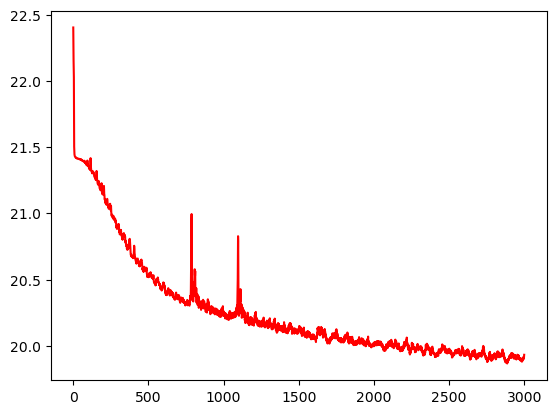

In [17]:
# feature_size, hidden_size, output_size
ODT = OnlineDesionTransformer(27,512,3).to(device)
num_epoch = 3000
Lambda = 1
# optimizer = torch.optim.SGD(net.parameters(),lr=0.5)
optimizer = torch.optim.Adam(ODT.parameters(),lr=0.001)
# loss_func = torch.nn.MSELoss()
loss_func = torch.nn.CrossEntropyLoss()
Loss=[]
for t in range(num_epoch):
    aver_loss = 0
    for batch, data in enumerate(data_train_loader):
        x, y, z = data
        # print(x.shape)
        prediction = ODT(x)
        # prediction = torch.transpose(prediction, dim0=0, dim1=1)
        Entropy = torch.mean(shannon_entropy(prediction))
        
        # add shannon entropy to encourage exploring
        loss = loss_func(prediction,y) - Lambda * Entropy 

        optimizer.zero_grad()
        loss.backward()   
        optimizer.step()   
        aver_loss += loss
    aver_loss /= batch
    aver_loss=aver_loss.cpu().detach().numpy()
    print('Loss of episode %s ='%t,aver_loss)
    Loss.append(aver_loss)

plt.plot(Loss,color='r')

## Training accuracy

In [19]:
Truth = []
Pred = []
aver_loss = 0
total_acc = 0
for batch, data in enumerate(data_train_loader):
# for batch, data in enumerate(data_full_loader):
# for x,y in data_train_loader:
    x, y, _ = data
    # print(x)
    # prediction =net(x)
    test = ODT(x)
    # test = torch.transpose(test, dim0=0, dim1=1)
    # print(test)
    # print(y)
    # print(loss.data)
    # print(y[0])
    # print(test[0])
    a = torch.argmax(test,dim = 2).cpu().data.numpy()
    b = torch.argmax(y,dim = 2).cpu().data.numpy()
    # print(a)
    # print(b)
    # print(sum(a==b))
    aver_acc = sum(sum(a==b))/length
    # print(aver_acc)
    total_acc += aver_acc
    # print(total_acc)
    # print(aver_acc)
# print(batch)
print('acc =', total_acc/(0.8*max_number_traj))


acc = 0.846734375


## Inference accuracy

In [20]:

Loss=[]
Truth = []
Pred = []
aver_loss = 0
total_acc = 0
for batch, data in enumerate(data_test_loader):
    x, y, _ = data
    ODT.eval()
    test = ODT(x)
    a = torch.argmax(test,dim = 2).cpu().data.numpy()
    b = torch.argmax(y,dim = 2).cpu().data.numpy()
    # print('-----------')
    # print('pred =',a[0])
    # print('true =',b[0])
    aver_acc = sum(a[0]==b[0])/length
    total_acc += aver_acc
print('acc =', total_acc/(0.2*max_number_traj))

acc = 0.6459374999999996


## AUC

In [21]:
from sklearn.metrics import precision_score, roc_curve, auc
n_classes = 3

aver_auc = np.zeros(n_classes)
total_precision = 0
Y_score = np.zeros(((length, int(0.2*max_number_traj), n_classes)))
# print(Y_score.shape)
Y_label = np.zeros(((length, int(0.2*max_number_traj), n_classes)))
for batch, data in enumerate(data_test_loader):
    x, y, _ = data
    # print(x)
    test = ODT(x)
    y_score = test[0].cpu().data.numpy()
    y_label = y[0].cpu().data.numpy()
    # print(batch)
    for i in range(length):
        Y_score[i][batch] = y_score[i]
        Y_label[i][batch] = y_label[i]
fpr = dict()
tpr = dict()
roc_auc = dict()
aver_auc = np.zeros(n_classes)
for t in range(length):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_label[t][:, i], Y_score[t][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        # aver_auc[i] += auc(fpr[i], tpr[i])
        aver_auc[i] += roc_auc[i]/length
    print('step %s AUC ='%(t+1),roc_auc)
print('Average AUC =', aver_auc)
    # precision = precision_score(a,b, average="micro")
    # total_precision += precision
# aver_precesion = total_precision/batch
# print(aver_precesion)
# print(aver_auc)

step 1 AUC = {0: 0.6694047619047618, 1: 0.6334124433803094, 2: 0.659253708167082}
step 2 AUC = {0: 0.7329800623587631, 1: 0.705419819971752, 2: 0.7125887445887445}
step 3 AUC = {0: 0.7522425081480199, 1: 0.7440124895861775, 2: 0.752158817154572}
step 4 AUC = {0: 0.7433945135477448, 1: 0.7626247189790194, 2: 0.7422559207006281}
step 5 AUC = {0: 0.7809841849914939, 1: 0.7978203037844332, 2: 0.7792953409651702}
step 6 AUC = {0: 0.8122640491856327, 1: 0.7868100864045142, 2: 0.7986642137848999}
step 7 AUC = {0: 0.8131324404761904, 1: 0.799659342531085, 2: 0.8163047619047619}
step 8 AUC = {0: 0.7837218694295901, 1: 0.7689278923919521, 2: 0.7906423361775226}
step 9 AUC = {0: 0.7829756976711442, 1: 0.7914852542512116, 2: 0.7991904182597613}
step 10 AUC = {0: 0.7719361881709554, 1: 0.8119434508601601, 2: 0.7965635688170775}
step 11 AUC = {0: 0.8053488486483827, 1: 0.8148771872176128, 2: 0.8267258833518385}
step 12 AUC = {0: 0.8150095238095239, 1: 0.8305861508520567, 2: 0.8046998932825705}
step 

In [22]:
# aver_acc = np.zeros(length)
# for batch, data in enumerate(data_test_loader):
# # for batch, data in enumerate(data_full_loader):
# # for x,y in data_train_loader:
#     x, y = data
#     # print(x)
#     # prediction =net(x)
#     test = gru(x)
#     # print(test)
#     # print(y)
#     a = torch.argmax(test,dim = 2).cpu().data.numpy()
#     b = torch.argmax(y,dim = 2).cpu().data.numpy()
#     # print('-----------')
#     # print('predict =',a.T[0])
#     # print('true =',b[0])
#     for i in range(length):
#         aver_acc[i] += a.T[0][i]==b[0][i]
# aver_acc /= batch
# print('step acc =', aver_acc)
# print('aver acc =', sum(aver_acc)/length)


In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score

aver_f1 = 0
aver_p = 0
aver_r = 0

# print(y_pred)
# print(y_true)
for i in range(length):
  y_true = np.argmax(Y_label[i],axis = 1)
  y_pred = np.argmax(Y_score[i],axis = 1)
  f1 = round(f1_score(y_true, y_pred, average='macro' ),4)
  p = round(precision_score(y_true, y_pred, average='macro'),4)
  r = round(recall_score(y_true, y_pred, average='macro'),4)
  aver_f1 += f1/length
  aver_p += p/length
  aver_r += r/length
  print('Step %s:'%(i+1),'F1 =', f1, 'Precision =', p, 'Recall =', r)
print('Aver_F1 =', round(aver_f1,4), 'Aver_Precision =', round(aver_p,4), 'Aver_Recall =', round(aver_r,4))

Step 1: F1 = 0.5026 Precision = 0.5044 Recall = 0.5033
Step 2: F1 = 0.5599 Precision = 0.5618 Recall = 0.5603
Step 3: F1 = 0.6092 Precision = 0.6105 Recall = 0.6091
Step 4: F1 = 0.6017 Precision = 0.6037 Recall = 0.6026
Step 5: F1 = 0.6629 Precision = 0.6646 Recall = 0.6624
Step 6: F1 = 0.6532 Precision = 0.6582 Recall = 0.6557
Step 7: F1 = 0.6754 Precision = 0.6791 Recall = 0.6773
Step 8: F1 = 0.6504 Precision = 0.651 Recall = 0.651
Step 9: F1 = 0.6576 Precision = 0.66 Recall = 0.6584
Step 10: F1 = 0.6609 Precision = 0.6614 Recall = 0.6624
Step 11: F1 = 0.6939 Precision = 0.6939 Recall = 0.6952
Step 12: F1 = 0.705 Precision = 0.7054 Recall = 0.7054
Step 13: F1 = 0.6716 Precision = 0.6742 Recall = 0.6739
Step 14: F1 = 0.6864 Precision = 0.6939 Recall = 0.6882
Step 15: F1 = 0.6535 Precision = 0.6562 Recall = 0.6543
Step 16: F1 = 0.6625 Precision = 0.6632 Recall = 0.6626
Step 17: F1 = 0.6932 Precision = 0.6983 Recall = 0.6956
Step 18: F1 = 0.6461 Precision = 0.6499 Recall = 0.6485
Step 1

In [24]:

True_Click_matrix = np.zeros((800,20))
True_Action_matrix = np.zeros((800,20))
Click_pred_matrix = np.zeros((800,20))
Action_pred_matrix = np.zeros((800,20))

# print(Click_pred_matrix)

for batch, data in enumerate(data_test_loader):
# for batch, data in enumerate(data_full_loader):
# for x,y in data_train_loader:
    ODT.eval()
    x, y, z = data
    action_true = torch.squeeze(torch.argmax(y,dim = 2)).cpu().data.numpy()
    click_true = torch.squeeze(z).cpu().data.numpy()
    True_Click_matrix[batch] = click_true
    # True_Action_count += np.sum(action_true, axis = 0)
    
    action = ODT(x)
    action_pred = torch.squeeze(torch.argmax(action,dim = 2)).cpu().data.numpy()
    # print(action_true == action_pred)
    Action_pred_matrix[batch] = (action_true == action_pred)
    # click_pred = torch.squeeze(click).cpu().data.numpy()
    # Click_pred_matrix[batch] = click_pred
True_click = sum(sum(True_Click_matrix))
Cost = 8000
Click = sum(sum(Action_pred_matrix*True_Click_matrix))
cpc = Cost/Click
print('Policy_cost = ', Cost)
print('Policy click number = ', Click) 
print('Policy_CPC =', cpc)


Policy_cost =  8000
Policy click number =  1914.0
Policy_CPC = 4.179728317659352
